In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import copy
import torch
import pickle
import numpy as np

In [3]:
class Dict2Obj:
  def __init__(self, dict):
    for key in dict:
      self.__dict__[key] = dict[key]

In [4]:

base_scale = 6
base_offset = torch.tensor([0, -0.6, -0.15])
translation_scale = torch.tensor(base_scale/1.25)
translation_offset = translation_scale * base_offset

# import argparse
# parser = argparse.ArgumentParser(description='iNeRF')
# parser.add_argument('--config', type=str, default='configs/nerf_hash.yaml', help='Path to config file.')
# parser.add_argument('--valid-only', action='store_true', help='Only validate.', default=True)

# # parser.add_argument('-p', '--pretrained', type=str, default='', help='Path to pretrained model.')
# parser.add_argument('-mn', '--model-name', type=str, default='', help='name of pretrained model.')
# parser.add_argument('-dp', '--dataset-path', type=str, default='', help='Path to dataset.')

# parser.add_argument('-o', '--output', type=str, default='', help='Path to output directory.')
# parser.add_argument('-c2w1', '--target-c2w-path1', type=str, help='Path to target c2w_pickle file.')
# parser.add_argument('-c2w2', '--target-c2w-path2', type=str, help='Path to target c2w_pickle file.')

# parser.add_argument('--c2w_ans', type=str, help='Path to ans c2w_pickle file.')
# args = parser.parse_args()
args = Dict2Obj({
  "model_name" : "workdir/cheezit_5_2_val4_1/rob0_cheezit_single_side_env_nobg_sam_iteration_11",
  "dataset_path" : "/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val4_perfectinerf2/merged_images_20",
  "input" : "../notebooks_input",
  "output" : "../notebooks_output/pc",
  "dil_iter" : 3
  # "target_c2w_path1" : "../notebooks_output/post_flip_pre_inerf_c2w0.pkl",
})

root_dir = '/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/' + args.model_name + '/'
model_dir = os.path.join(root_dir, f"model_1")
model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")

sys.argv[1:] = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    f'--pretrained={model_path}',
    f'--dataset-path={args.dataset_path}',
    '--valid-only'
]

W, H = 800, 800

fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 1e-3,
}

In [ ]:
ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays

from scipy.spatial.transform import Rotation as R

from wisp.framework import WispState
from inerf_utils import *
from kaolin.render.camera import Camera, PinholeIntrinsics, CameraExtrinsics, CameraIntrinsics, blender_coords, opengl_coords
from kaolin.render.camera.extrinsics_backends import _Matrix6DofRotationRep

from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

from scipy.optimize import minimize
from scipy.optimize import differential_evolution as de
from scipy.linalg import expm
from scipy.linalg import logm

import open3d as o3d
import plotly.express as px

In [ ]:

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
  pipeline = torch.load(args.pretrained)
  pipeline.to(extra_args['device'])
  scene_state = WispState()
  trainer = load_trainer(
      pipeline=pipeline,
      train_dataset=train_dataset, 
      validation_dataset=validation_dataset,
      device=extra_args['device'], 
      scene_state=scene_state,
      args=args, 
      args_dict=args_dict
  )
  return trainer, pipeline

def gen_camera(pose, focal, w, h, far):
  view_matrix = torch.linalg.inv(pose)

  x0 = 0.0
  y0 = 0.0

  camera = Camera.from_args(
      view_matrix=view_matrix,
      focal_x=focal,
      focal_y=focal,
      width=w,
      height=h,
      far=far,
      near=0.0,
      x0=x0,
      y0=y0,
      dtype=torch.float32,
      device=extra_args['device'],
      requires_grad=True
  )
  camera.change_coordinate_system(blender_coords())

  return camera

def gen_rays_only(camera):
  ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
  rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
  rays = Rays.stack(rays)
  return rays


In [5]:
inerf_args, inerf_args_dict = parse_args()
train_dataset, validation_dataset = load_dataset(args=inerf_args)

['val', 'train', 'transforms_train.json', 'transforms_test.json', 'transforms_val.json']
<class 'wisp.datasets.formats.nerf_standard_dataset.NeRFSyntheticDataset'>
True
<class 'wisp.datasets.formats.rtmv_dataset.RTMVDataset'>
False


loading data:   0%|          | 0/15 [00:00<?, ?it/s]

loading data: 100%|██████████| 15/15 [00:00<00:00, 65.17it/s]


128.66666666666666


/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
loading data: 100%|██████████| 67/67 [00:01<00:00, 61.41it/s]


155.46740898662756


In [6]:
os.makedirs(extra_args['output'], exist_ok=True)

z_near, z_far = extra_args['z_near'], extra_args['z_far']
model, pipeline = make_model(
    inerf_args, inerf_args_dict, extra_args, train_dataset, validation_dataset)

num_images = 4
target_images_np = []
target_images_flatten = []
input_poses = []
depths = []
masks = []

for idx in range(num_images):
    target_images_np.append(cv2.resize(cv2.imread(f'{args.output}/gt_image{idx}.png', cv2.IMREAD_UNCHANGED), (W, H), interpolation=cv2.INTER_AREA))
    # target_images_np[idx] = cv2.cvtColor(target_images_np[idx], cv2.COLOR_BGRA2RGBA)
    # target_images_np[idx] = target_images_np[idx][..., :3] * target_images_np[idx][..., -1] + (1 - target_images_np[idx][..., -1])
    
    target_images_np[idx] = cv2.cvtColor(target_images_np[idx], cv2.COLOR_BGRA2RGB)

    target_images_flatten.append(np.reshape(target_images_np[idx], [-1, 4]) / 255.0)
    target_images_flatten[idx] = torch.from_numpy(target_images_flatten[idx]).float().to(device=extra_args['device'])

    input_poses.append(pickle.load(open(f'{args.output}/post_flip_c2w_ws{idx+1}.pkl', 'rb')))
    # input_poses[idx][:3,-1] *= translation_scale.numpy()
    # input_poses[idx][:3,-1] += translation_offset.numpy()

    depths.append(pickle.load(open(f'{args.output}/gt_depth{idx}.pkl', 'rb')))
    masks.append(cv2.imread(f'{args.output}/mask/gt_image{idx}.png', cv2.IMREAD_UNCHANGED))
  

c2w_ans = pickle.load(open(f'{args.input}/c2w_ans.pkl', 'rb'))
# c2w_ans = pickle.load(open('/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val4_perfectinerf2/pose_actual/iter_9.pkl', 'rb'))

# c2w_ans[:3,-1] *= translation_scale.numpy()
# c2w_ans[:3,-1] += translation_offset.numpy() 

def get_image(cam):
    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))
    rb = model.renderer.render(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    depth = rb.depth.detach().cpu().numpy().reshape((H, W))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W))
    depth[alpha <= 0.1] = 10
    depth[alpha > 0.1] = depth[alpha > 0.1] / alpha[alpha > 0.1]
    return rgb, depth, alpha

def render_pipeline(renderer, pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(renderer.render_batch):
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx, **renderer.kwargs)
    return rb

In [7]:
# num_points = 75
# coords = torch.stack(torch.meshgrid(
#   torch.linspace(-0.15, 0.15, num_points),
#   torch.linspace(0.45, 0.75, num_points),
#   torch.linspace(0, 0.3, num_points),
# ), dim=-1).reshape(-1, 3).cuda()

# scaled_coords = coords * translation_scale.cuda() + translation_offset.cuda()
# scaled_coords = scaled_coords @ torch.tensor([[1, 0, 0], [0, 0, 1], [0, -1, 0]], dtype=torch.float32).cuda().T
# dirs = torch.ones(num_points**3, 3).cuda() * torch.tensor([1, 0, 0], dtype=torch.float32).cuda()
# density = pipeline.nef.rgba(scaled_coords, dirs)['density'].detach().cpu().numpy().reshape(-1)

In [8]:
# # sample points from coords with each point having a probability of being sampled proportional to its density
# prob = torch.rand_like(torch.tensor(density)).numpy()
# select = prob < density
# coords = coords[torch.tensor(select).cuda()]
# selected_density = density[select]

# mask = selected_density > selected_density.mean()
# coords = coords[torch.tensor(mask).cuda()]
# selected_density = selected_density[mask]

In [9]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# point_cloud_scaled = scaler.fit_transform(coords.cpu().numpy())
# eps = 0.2  # Adjust the neighborhood distance
# min_samples = 10  # Adjust the minimum number of points in a cluster
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# labels = dbscan.fit_predict(point_cloud_scaled)
# refined_point_cloud = coords[torch.tensor(labels).cuda() != -1]
# refined_density = selected_density[labels != -1]



In [10]:
# import plotly.graph_objects as go

# def generate_fig(pcd, density):
#   fig = go.Figure(data=[go.Scatter3d(
#     x=pcd[:,0], 
#     y=pcd[:,1], 
#     z=pcd[:,2], 
#     mode='markers',
#     marker=dict(
#       size=1.5,
#       color=density,
#       colorscale='plasma',  # You can choose a different colorscale
#       opacity=0.8,
#       colorbar=dict(title='Selected Density', tickvals=[min(density), max(density)],
#                         ticktext=['Low', 'High'], ticks='outside')
#     )
#   )])
#   fig.update_layout(scene=dict(
#     aspectmode="data",
#     xaxis=dict(title='X', range=[-0.15, 0.15]),
#     yaxis=dict(title='Y', range=[0.45, 0.75]),
#     zaxis=dict(title='Z', range=[0, 0.3]),
#   ))
#   return fig
# generate_fig(refined_point_cloud.cpu().numpy(), refined_density).show()

In [11]:
# nerf_pcd = o3d.geometry.PointCloud()
# refined_density = refined_density / np.max(refined_density)

# nerf_pcd.points = o3d.utility.Vector3dVector(refined_point_cloud.cpu().numpy())
# d = refined_density.astype(np.float64)
# nerf_pcd.colors = o3d.utility.Vector3dVector(np.stack([d, d, d], axis=-1))

# # nerf_pcd.estimate_normals()
# # # use ball pivoting to create surface mesh
# # surface_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(nerf_pcd, o3d.utility.DoubleVector([0.01, 0.02]))
# # # save surface mesh
# # o3d.io.write_triangle_mesh(f"{args.output}/mesh.ply", surface_mesh)
# # # Compute normals for the point cloud
# # nerf_pcd.compute_vertex_normals()
# # # pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# # # surface_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(nerf_pcd, depth=10)

# # surface_pointcloud = surface_mesh.sample_points_uniformly(number_of_points=10000)

# # generate_fig(np.asarray(surface_pointcloud.points), refined_density).show()

In [12]:
import open3d as o3d

def create_point_cloud(rgb_image, depth_image, c2w, intrinsics, idx=0):
  fx, fy, cx, cy = intrinsics
  xmap, ymap = np.arange(depth_image.shape[0]), np.arange(depth_image.shape[1])
  # ymap, xmap = np.meshgrid(xmap, ymap)
  xmap, ymap = np.meshgrid(xmap, ymap)

  points_z = depth_image
  points_x = (xmap - cx) / fx * points_z
  points_y = (ymap - cy) / fy * points_z

  # points_x, points_y, points_z = points_y.flatten(), points_x.flatten(), -points_z.flatten()
  points_x, points_y, points_z = points_x.flatten(), -points_y.flatten(), -points_z.flatten()
  points_4d = np.stack([points_x, points_y, points_z, np.ones_like(points_x)], axis=1)

  # points_reshaped = points_4d[:,:3].reshape(800,800,3)
  # if idx == 0:
  #   print(np.array2string(points_reshaped[550,500], separator=","))
  #   print(np.array2string(points_reshaped[400,500], separator=","))
  # else:
  #   print(np.array2string(points_reshaped[550,250], separator=","))
  #   print(np.array2string(points_reshaped[400,250], separator=","))


  points = points_4d @ c2w.T
  colors = rgb_image.reshape(-1, 3)
  points = points[:,:3]
  colors = colors / 255.

  # points_reshaped = points.reshape(800,800,3)
  # if idx == 0:
  #   print(np.array2string(points_reshaped[550,500], separator=","))
  #   print(np.array2string(points_reshaped[400,500], separator=","))
  # else:
  #   print(np.array2string(points_reshaped[550,250], separator=","))
  #   print(np.array2string(points_reshaped[400,250], separator=","))

  pcd = o3d.geometry.PointCloud()
  # print(points.shape)
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)
  return pcd

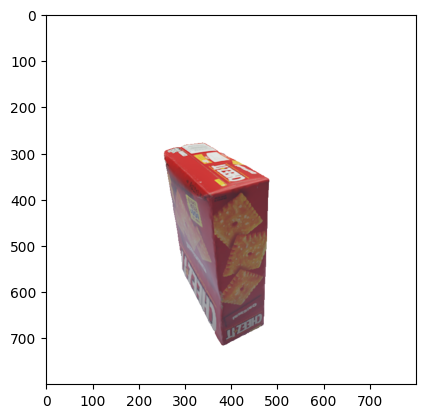

In [65]:
plt.imshow(target_images_np[3])

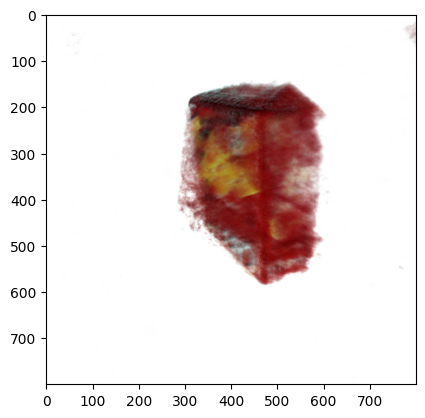

In [67]:
plt.imshow(rgb)

In [69]:
fx, fy = 514.6666, 514.6666
cx, cy = 400, 400
intrinsic = o3d.camera.PinholeCameraIntrinsic(W,H,fx,fy,cx,cy)

#create empty point cloud
final_point_cloud = o3d.geometry.PointCloud()
gt_pcs = []
for idx in range(num_images):
  # rgb_image = o3d.io.read_image(f'../notebooks_sam_input/gt_image{idx}.png')
  depth_masked = depths[idx].copy()
  depth_masked[masks[idx] == 0] = 0
  point_cloud = create_point_cloud(target_images_np[idx], depth_masked, input_poses[idx], [fx, fy, cx, cy], idx)
  print(point_cloud)
  point_cloud = point_cloud.voxel_down_sample(voxel_size=0.001)
  point_cloud, ind = point_cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
  gt_pcs.append(point_cloud)
  final_point_cloud += point_cloud

# fill the inside of the pointcloud with points

trans_mat = np.array([[-1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
final_point_cloud.transform(trans_mat)

o3d.io.write_point_cloud(f'{args.output}/point_cloud.pcd', final_point_cloud) 

PointCloud with 640000 points.
PointCloud with 640000 points.
PointCloud with 640000 points.
PointCloud with 640000 points.


True

In [54]:
flip_transform = pickle.load(open('/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val4_perfectinerf2/iter_8_out/flip_transform.pkl', 'rb'))
# flip_transform[:3,-1] -= translation_offset
# flip_transform[:3,-1] /= translation_scale

In [55]:
flip_transform

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.        ,  0.        ,  1.20000005],
       [ 0.        ,  0.        , -1.        ,  0.30000001],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [66]:
scale = translation_scale.item()
# fx, fy = 514.6666*scale, 514.6666*scale
fx, fy = 514.6666, 514.6666
cx, cy = 400, 400

pred_point_cloud = o3d.geometry.PointCloud()
pred_pcs = []
for idx in range(num_images):
  curr_pose = input_poses[idx].copy()
  curr_pose = np.linalg.inv(flip_transform) @ curr_pose
  curr_pose = torch.tensor(curr_pose)
  curr_pose[:3,-1] *= translation_scale
  curr_pose[:3,-1] += translation_offset
  temp_camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
  rgb, depth, alpha = get_image(temp_camera)
  rgb = (rgb * 255).astype(np.uint8)
  mask = (alpha > 0.1)
  depth = depth / scale
  # rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
  # cv2.imwrite(f'../notebooks_output/pc/pred_image{idx}.png',(rgb * 255).astype(np.uint8))
  print(rgb.shape)
  depth[mask == 0] = 0
  # rgb[mask == 0] = 0

  point_cloud = create_point_cloud(rgb, depth, input_poses[idx], [fx, fy, cx, cy], idx)
  print(point_cloud)
  point_cloud = point_cloud.voxel_down_sample(voxel_size=0.001)
  point_cloud, ind = point_cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
  pred_point_cloud += point_cloud
  pred_pcs.append(point_cloud)
  o3d.io.write_point_cloud(f'{args.output}/pred_point_cloud.pcd', pred_point_cloud)

(800, 800, 3)
PointCloud with 640000 points.
(800, 800, 3)
PointCloud with 640000 points.
(800, 800, 3)
PointCloud with 640000 points.
(800, 800, 3)
PointCloud with 640000 points.


In [19]:
print(np.asanyarray(pred_point_cloud.points)[0])
print(np.asanyarray(final_point_cloud.points)[0])

[ 0.05901588  0.5874165  -0.00994859]
[-0.0747701  -0.61035558 -0.01670793]


In [70]:

print(flip_transform)

reg_p2p = o3d.pipelines.registration.registration_icp(
    pred_pcs[2], gt_pcs[2], 0.001, np.eye(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=500)
)

reg_p2p.transformation

[[ 1.          0.          0.          0.        ]
 [ 0.         -1.          0.          1.20000005]
 [ 0.          0.         -1.          0.30000001]
 [ 0.          0.          0.          1.        ]]


array([[ 9.99992348e-01,  4.78572819e-04,  3.88270624e-03,
        -1.42673177e-03],
       [-4.54148445e-04,  9.99980121e-01, -6.28899895e-03,
         1.47036320e-03],
       [-3.88563880e-03,  6.28718750e-03,  9.99972686e-01,
        -3.98323700e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

tensor([[-5.1263e-01,  3.9286e-01, -7.6346e-01, -1.1469e+00],
        [-8.5861e-01, -2.3402e-01,  4.5610e-01,  7.3962e-01],
        [ 5.1979e-04,  8.8932e-01,  4.5728e-01,  7.4929e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)

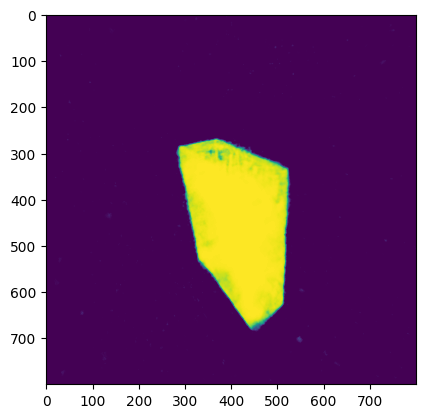

In [42]:
plt.imshow(alpha)

In [27]:
!ls ../notebooks_output/pc/pred_image0.png

../notebooks_output/pc/pred_image0.png


In [17]:
final_point_cloud

PointCloud with 162532 points.

In [18]:
final_point_cloud.estimate_normals()

In [19]:
# surface_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(final_point_cloud, o3d.utility.DoubleVector([0.01, 0.02]))
surface_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(final_point_cloud, depth=8)

In [21]:
surface_pointcloud = surface_mesh[0].sample_points_uniformly(number_of_points=100000)
# save surface point cloud
o3d.io.write_point_cloud(f'{args.output}/surface_point_cloud.pcd', surface_pointcloud)

True

In [22]:
# save the surface mesh[0]
o3d.io.write_triangle_mesh(f"{args.output}/mesh.ply", surface_mesh[0])

True

In [37]:
icp_result = o3d.pipelines.registration.registration_icp(
    final_point_cloud, nerf_pcd, max_correspondence_distance=0.05,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
)

# Get the transformation matrix
transformation_matrix = icp_result.transformation

print("Transformation matrix:")
print(transformation_matrix)


Transformation matrix:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [38]:
nerf_pcd

PointCloud with 19849 points.

In [39]:
final_point_cloud

PointCloud with 162532 points.

In [35]:
input_poses[0]

array([[ 0.50548813, -0.39165853,  0.76882075,  0.26789515],
       [ 0.8628253 ,  0.22555118, -0.45239272,  0.45636617],
       [ 0.00377504,  0.89203714,  0.45194633,  0.30196049],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [45]:
input_poses[1]

array([[ 0.5168, -0.0012, -0.8561, -0.2401],
       [-0.856 ,  0.008 , -0.5168,  0.447 ],
       [ 0.0075,  1.    ,  0.0032,  0.1624],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [46]:
input_poses[2]

array([[-0.5169, -0.001 ,  0.856 ,  0.2405],
       [ 0.856 , -0.008 ,  0.5169,  0.7518],
       [ 0.0063,  1.    ,  0.005 ,  0.1624],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [47]:
input_poses[3]

array([[-0.5167,  0.0006, -0.8562, -0.2424],
       [-0.8562, -0.004 ,  0.5167,  0.7535],
       [-0.0031,  1.    ,  0.0025,  0.1614],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

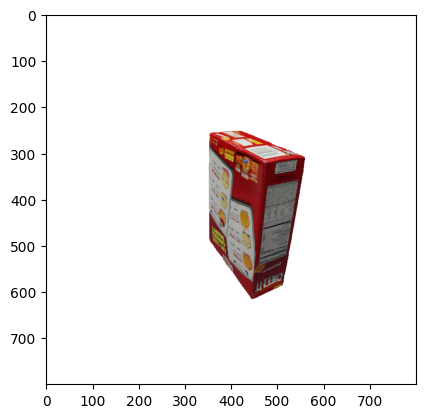

In [32]:
plt.imshow(target_images_np[0]) 

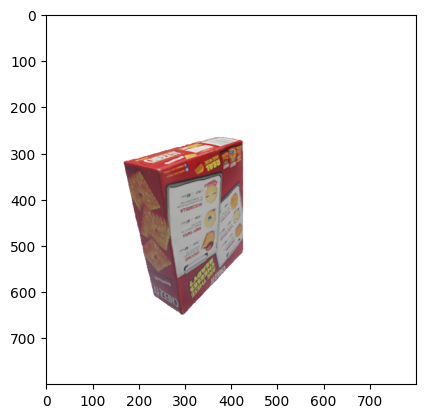

In [33]:
plt.imshow(target_images_np[1])

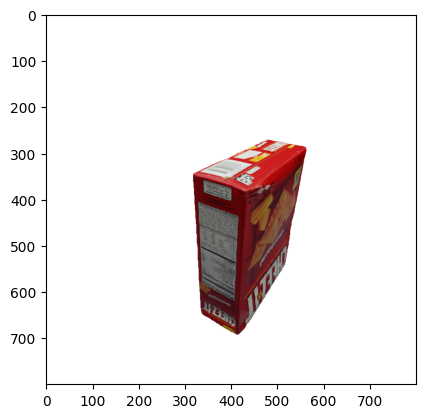

In [34]:
plt.imshow(target_images_np[2])

In [84]:
fx, fy = 514, 514
cx, cy = 400, 400
intrinsic = o3d.camera.PinholeCameraIntrinsic(W,H,fx,fy,cx,cy)

#create empty point cloud
final_point_cloud = o3d.geometry.PointCloud()

for idx in range(4):
  rgb_image = o3d.io.read_image(f'../notebooks_sam_input/gt_image{idx}.png')
  depth_masked = depths[idx].copy()
  depth_masked[masks[idx] == 0] = 0
  depth_image = o3d.geometry.Image(depth_masked * 1000)

  rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=rgb_image,
    depth=depth_image,
    convert_rgb_to_intensity=False
  )

  pose = input_poses[idx] @ np.array([[0,1,0,0],[1,0,0,0],[0,0,-1,0],[0,0,0,1]])
  point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    image=rgbd_image,
    intrinsic=intrinsic,
    extrinsic=pose
  )
  #append point_cloud to final_point_cloud
  # print(point_cloud)
  # print(point_cloud.)
  # point_cloud = create_point_cloud(target_images_np[idx], depth_masked, input_poses[idx], [fx, fy, cx, cy])
  final_point_cloud += point_cloud
# trans_mat = np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
# final_point_cloud.transform(trans_mat)
# final_point_cloud = final_point_cloud.voxel_down_sample(voxel_size=0.02) 
o3d.io.write_point_cloud(f'{args.output}/point_cloud.pcd', final_point_cloud) 

True

In [ ]:
np.asarray(final_point_cloud).max()

In [39]:
depths[0][400, 400], depths[0][400, 200]

(0.2679315, 0.20970395)

In [47]:
fx, fy = 514.6, 514.6
cx, cy = 400, 400
final_point_cloud = o3d.geometry.PointCloud()

for i in range(2):
  depth_image = depths[i]
  rgb_image = target_images_np[i]
  c2w = input_poses[i]

  xmap, ymap = np.arange(depth_image.shape[0]), np.arange(depth_image.shape[1])
  ymap, xmap = np.meshgrid(xmap, ymap)
  points_z = depth_image
  points_x = (xmap - cx) / fx * points_z
  points_y = (ymap - cy) / fy * points_z

  y = 250 if i == 1 else 500
  points_x, points_y, points_z = points_y, points_x, -points_z

  print(points_z[400,400], points_z[400,y])
  print(points_x[400,400], points_x[400,y])
  print(points_y[400,400], points_y[400,y])

  points_4d = np.stack([points_x.flatten(), points_y.flatten(), points_z.flatten(), np.ones_like(points_x.flatten())], axis=1)
  points = points_4d @ c2w.T
  points = points[:,:3]

  colors = rgb_image.reshape(-1, 3)
  colors = colors / 255
  
  points_reshaped = points.reshape(800,800,3)
  print(points_reshaped[400,400], points_reshaped[400,y])
  print()
  points = points.reshape(-1, 3)
  # create point cloud from points and colors
  pcd = o3d.geometry.PointCloud()
  print(points.shape)
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)

  pcd = pcd.voxel_down_sample(voxel_size=0.001)
  pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

  final_point_cloud += pcd
# return pcd
# o3d.io.write_point_cloud(f'{args.output}/point_cloud.pcd', final_point_cloud) 



-0.30528384 -0.23824686
0.0 0.04629748506023408
0.0 0.0
[0.00160074 0.60986013 0.15111059] [0.07546058 0.61358579 0.1852904 ]

(640000, 3)
-0.35577202 -0.23774469
0.0 -0.06929985104578272
0.0 0.0
[0.0397602  0.60756012 0.13793289] [-0.08458383  0.62133082  0.19344729]

(640000, 3)


1

In [22]:
np.set_printoptions(precision=4, suppress=True, linewidth=120)
input_poses[0]

array([[ 0.5898, -0.4121,  0.6945,  0.2156],
       [ 0.8075,  0.3004, -0.5076,  0.456 ],
       [ 0.0006,  0.8602,  0.5099,  0.3073],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [90]:
input_poses[1]

array([[ 0.4638,  0.0019, -0.8859, -0.2382],
       [-0.8859,  0.008 , -0.4638,  0.4677],
       [ 0.0062,  1.    ,  0.0054,  0.1608],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [48]:
final_point_cloud

PointCloud with 246601 points.

In [49]:
# %env WEBRTC_IP=10.237.23.91
# %env WEBRTC_PORT=8889 
# from open3d.web_visualizer import draw
# save pointcloud in pcd file
# vis = o3d.visualization.Visualizer()
# draw(point_cloud)
# vis.run()
# cube_red = o3d.geometry.TriangleMesh.create_box(1, 2, 4)
# cube_red.compute_vertex_normals()
# cube_red.paint_uniform_color((1.0, 0.0, 0.0))
# draw(cube_red)

True

In [50]:
# from pyntcloud import PyntCloud
# my_point_cloud = PyntCloud.from_file(f'{args.output}/point_cloud.pcd')
# # display the pointcloud
# my_point_cloud.plot()

In [89]:
pts[:,2].min()

0.00019291495483268287

In [14]:
voxel_size = 0.02
voxel_centers = np.round(point_cloud / voxel_size) * voxel_size
unique_voxel_centers = {tuple(center) for center in voxel_centers.tolist()}
downsampled_pc = np.array(list(unique_voxel_centers))
downsampled_pc.shape, point_cloud.shape

((54877, 3), (640000, 3))

In [15]:
scaler = StandardScaler()
point_cloud_scaled = scaler.fit_transform(downsampled_pc)
eps = 0.2  # Adjust the neighborhood distance
min_samples = 10  # Adjust the minimum number of points in a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(point_cloud_scaled)
refined_point_cloud = downsampled_pc[labels != -1]

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
  x=downsampled_pc[:,0], 
  y=downsampled_pc[:,1], 
  z=downsampled_pc[:,2], 
  mode='markers',
  marker=dict(
    size=1.5,
    # color=refined_density,
    colorscale='plasma',  # You can choose a different colorscale
    opacity=0.8,
    # colorbar=dict(title='Selected Density', tickvals=[min(refined_density), max(refined_density)],ticktext=['Low', 'High'], ticks='outside')
  )
)])
fig.update_layout(scene=dict(
  aspectmode="data",
  # xaxis=dict(title='X', range=[-0.15, 0.15]),
  # yaxis=dict(title='Y', range=[0.45, 0.75]),
  # zaxis=dict(title='Z', range=[0, 0.3]),
))
fig.show()

In [36]:
# import plotly.express as px
# import pandas as pd
# df = pd.DataFrame(coords.cpu().numpy(), columns=['x', 'y', 'z'])
# df['y'], df['z'] = df['z'], -df['y']
# fig = px.scatter_3d(df, x='x', y='y', z='z', size=1, opacity=0.5)
# fig.show()

In [28]:
o3d.geometry.PointCloud.create_from_rgbd_image

<function open3d.cuda.pybind.geometry.PyCapsule.create_from_rgbd_image>

/tmp/ipykernel_60390/1496846877.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



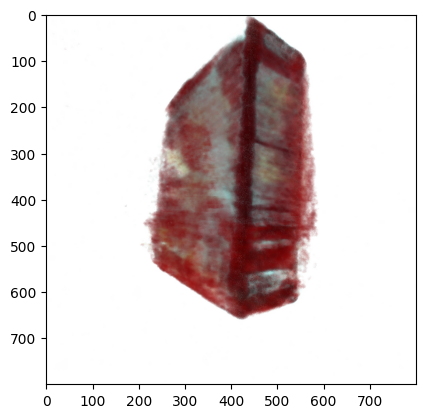

In [187]:
curr_pose = torch.tensor(input_poses[0])
temp_camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
plt.imshow(get_image(temp_camera)[0])

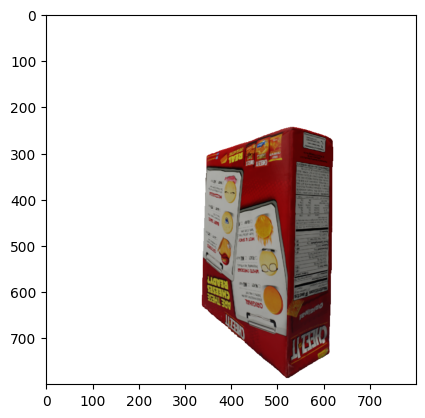

In [8]:
plt.imshow(target_images_np[0])

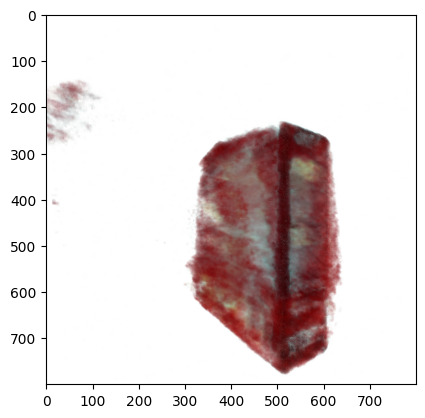

In [9]:
curr_pose = torch.tensor(c2w_ans)
temp_camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
plt.imshow(get_image(temp_camera)[0])

In [10]:
input_poses[0]

tensor([[ 0.5868,  0.0047,  0.8097,  0.9896],
        [-0.8097, -0.0045,  0.5868,  0.6981],
        [ 0.0064, -1.0000,  0.0012, -0.0502],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [11]:
c2w_ans

array([[ 0.54333177, -0.00898462,  0.83946999,  1.06887728],
       [-0.83832827, -0.05902458,  0.54196108,  0.88102438],
       [ 0.04468005, -0.9982161 , -0.03960199, -0.41516393],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [12]:
import torch.nn as nn

def vec2ss_matrix(vec):
  ss_matrix = torch.zeros((3,3)).cuda()
  ss_matrix[0, 1] = -vec[2]
  ss_matrix[0, 2] = vec[1]
  ss_matrix[1, 0] = vec[2]
  ss_matrix[1, 2] = -vec[0]
  ss_matrix[2, 0] = -vec[1]
  ss_matrix[2, 1] = vec[0]

  return ss_matrix

  
class camera_transf(nn.Module):
  def __init__(self):
    super(camera_transf, self).__init__()
    self.w = nn.Parameter(torch.normal(0., 1e-6, size=(3,)))
    self.v = nn.Parameter(torch.normal(0., 1e-6, size=(3,)))
    self.theta = nn.Parameter(torch.normal(0., 1e-6, size=()))

  def forward(self, x):
    exp_i = torch.zeros((4,4)).cuda()
    w_skewsym = vec2ss_matrix(self.w)
    exp_i[:3, :3] = torch.eye(3).cuda() + torch.sin(self.theta) * w_skewsym + (1 - torch.cos(self.theta)) * torch.matmul(w_skewsym, w_skewsym)
    exp_i[:3, 3] = torch.matmul(torch.eye(3).cuda() * self.theta + (1 - torch.cos(self.theta)) * w_skewsym + (self.theta - torch.sin(self.theta)) * torch.matmul(w_skewsym, w_skewsym), self.v)
    exp_i[3, 3] = 1.
    # print(exp_i.dtype, x.dtype)
    T_i = torch.matmul(exp_i, x)
    return T_i

In [13]:
torch.eye(3).device

device(type='cpu')

In [17]:
OVERLAY = True
lrate = 0.003
device = 'cuda'
batch_size = 512
kernel_size = 3
max_steps = 300


coords = np.asarray(np.stack(np.meshgrid(np.linspace(0, W - 1, W), np.linspace(0, H - 1, H)), -1),dtype=int)

POI = find_POI(target_images_np[0])
interest_regions = np.zeros((H, W, ), dtype=np.uint8)
interest_regions[POI[:,1], POI[:,0]] = 1
I = args.dil_iter
interest_regions = cv2.dilate(interest_regions, np.ones((kernel_size, kernel_size), np.uint8), iterations=I)
interest_regions = np.array(interest_regions, dtype=bool)
interest_regions = coords[interest_regions]

coords = coords.reshape(H * W, 2)
ray_grid = generate_centered_pixel_coords(W, H, W, H, device=extra_args['device'])
not_POI = set(tuple(point) for point in coords) - set(tuple(point) for point in POI)
not_POI = np.array([list(point) for point in not_POI]).astype(int)
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)


sampling_strategy = 'random'
start_pose = input_poses[0]
img2mse = lambda x, y : torch.mean((x - y) ** 2)
# start_pose = c2w_ans

start_pose = torch.tensor(start_pose, dtype=torch.float32).to(device)
cam_transf = camera_transf().to(device)
optimizer = torch.optim.Adam(params=cam_transf.parameters(), lr=lrate, betas=(0.9, 0.999))

testsavedir = args.output
# os.makedirs(testsavedir, exist_ok=True)

# imgs - array with images are used to create a video of optimization process
if OVERLAY is True:
    imgs = []


for k in range(max_steps):

    if sampling_strategy == 'random':
        rand_inds = np.random.choice(coords.shape[0], size=batch_size, replace=False)
        batch = coords[rand_inds]

    elif sampling_strategy == 'interest_point':
        if POI.shape[0] >= batch_size:
            rand_inds = np.random.choice(POI.shape[0], size=batch_size, replace=False)
            batch = POI[rand_inds]
        else:
            batch = np.zeros((batch_size, 2), dtype=np.int)
            batch[:POI.shape[0]] = POI
            rand_inds = np.random.choice(not_POI.shape[0], size=batch_size-POI.shape[0], replace=False)
            batch[POI.shape[0]:] = not_POI[rand_inds]

    elif sampling_strategy == 'interest_region':
        rand_inds = np.random.choice(interest_regions.shape[0], size=batch_size, replace=False)
        batch = interest_regions[rand_inds]

    target_s = target_images_np[0][batch[:, 1], batch[:, 0]]
    target_s = torch.tensor(target_s).to(device) / 255.
    pose = cam_transf(start_pose)

    # rays_o, rays_d = get_rays(H, W, fx, pose)  # (H, W, 3), (H, W, 3)
    # rays_o = rays_o[batch[:, 1], batch[:, 0]]  # (N_rand, 3)
    # rays_d = rays_d[batch[:, 1], batch[:, 0]]
    # batch_rays = torch.stack([rays_o, rays_d], 0)

    # rgb, disp, acc, extras = render(H, W, fx, chunk=args.chunk, rays=batch_rays, verbose=k < 10, retraw=True, **render_kwargs)

    curr_camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
    # curr_camera.switch_backend('matrix_6dof_rotation')
    # curr_camera.extrinsics.requires_grad = True
    
    rays = generate_pinhole_rays(curr_camera, ray_grid).reshape(H, W, 3)
    rays = Rays.stack(rays)
    rays = rays[batch[:, 1], batch[:, 0]]
    rb = pipeline(rays)
    rgb = rb.rgb
    

    optimizer.zero_grad()
    loss = img2mse(rgb, target_s)
    loss.backward()
    optimizer.step()

    new_lrate = lrate * (0.8 ** ((k + 1) / 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

    if (k + 1) % 50 == 0 or k == 0:
        print('Step: ', k)
        print('Loss: ', loss)

        with torch.no_grad():
            pose_dummy = pose.cpu().detach().numpy()

            rot_error = angle_between_rotation_matrices(pose_dummy[:3,:3], c2w_ans[:3,:3])
            
            translation_error = np.linalg.norm(c2w_ans[:3,-1] - pose_dummy[:3,-1])
            print('Rotation error: ', rot_error)
            print('Translation error: ', translation_error)
            print('-----------------------------------')

        if OVERLAY is True:
            with torch.no_grad():
                # rgb, disp, acc, _ = render(H, W, focal, chunk=args.chunk, c2w=pose[:3, :4], **render_kwargs)
                # rgb = rgb.cpu().detach().numpy()
                rgb = get_image(curr_camera)
                
                rgb8 = to8b(rgb)
                ref = to8b(target_images_np[0])
                filename = os.path.join(testsavedir, str(k)+'.png')
                dst = cv2.addWeighted(rgb8, 0.7, ref, 0.3, 0)
                imageio.imwrite(filename, dst)
                imgs.append(dst)

if OVERLAY is True:
    imageio.mimwrite(os.path.join(testsavedir, 'video.gif'), imgs, duration=125) #quality = 8 for mp4 format


/tmp/ipykernel_53931/2735735981.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start_pose = torch.tensor(start_pose, dtype=torch.float32).to(device)


Step:  0
Loss:  tensor(0.1176, device='cuda:0', grad_fn=<MeanBackward0>)
Rotation error:  1.0483316922546306
Translation error:  0.4158841909856896
-----------------------------------
Step:  49
Loss:  tensor(0.1124, device='cuda:0', grad_fn=<MeanBackward0>)
Rotation error:  1.23890906459641
Translation error:  0.4347964466822383
-----------------------------------
Step:  99
Loss:  tensor(0.0879, device='cuda:0', grad_fn=<MeanBackward0>)
Rotation error:  3.2493157706805675
Translation error:  0.5668414323051065
-----------------------------------
Step:  149
Loss:  tensor(0.0865, device='cuda:0', grad_fn=<MeanBackward0>)
Rotation error:  6.277424716417658
Translation error:  0.7729340697782991
-----------------------------------
Step:  199
Loss:  tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>)
Rotation error:  8.246393168265417
Translation error:  0.9129947208746321
-----------------------------------
Step:  249
Loss:  tensor(0.0638, device='cuda:0', grad_fn=<MeanBackward0>)
Rot

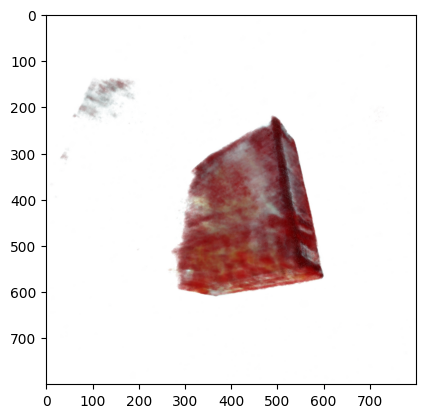

In [18]:
plt.imshow(get_image(curr_camera))

In [83]:
curr_camera.extrinsics

CameraExtrinsics of 1 cameras, device: cuda:0, dtype: torch.float32, backend: _Matrix6DofRotationRep.
Coordinates basis: 
tensor([[ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0., -1.,  0.]], device='cuda:0').
Extrinsic params: tensor([[ 0.5868,  0.0064,  0.8097,  0.0047, -1.0000,  0.0045, -0.0152, -0.0517,
         -1.2109]], device='cuda:0', grad_fn=<CatBackward0>)

In [54]:
pose

tensor([[ 0.5868,  0.0047,  0.8097,  0.9896],
        [-0.8097, -0.0045,  0.5868,  0.6981],
        [ 0.0064, -1.0000,  0.0012, -0.0502],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [61]:
curr_camera.parameters()

(tensor([[ 0.5868,  0.0064,  0.8097,  0.0047, -1.0000,  0.0045, -0.0152, -0.0517,
          -1.2109]], device='cuda:0'),
 tensor([[  0.0000,   0.0000, 514.6666, 514.6666]], device='cuda:0'))

In [ ]:
def get_euler_pose(rot_pose):
  best_params_se3 = rot_pose.reshape((4,4)).detach().cpu().numpy()
  best_params_euler = np.concatenate([R.from_matrix(best_params_se3[:3, :3]).as_euler('zxz', degrees=True), best_params_se3[:3, -1]])
  return best_params_euler

def get_rot_pose(euler_pose):
  r = R.from_euler('zxz', euler_pose[:3], degrees=True)
  t = euler_pose[3:]
  pose = np.eye(4)
  pose[:3,:3] = r.as_matrix()
  pose[:3, -1] = t
  return pose

def get_se3_pose(pose_6d):
    a,b,c = pose_6d[3:]
    skm = np.array([[0,a,b], [-a,0,c], [-b,-c,0]])
    rot = expm(skm)
    se3_pose = np.eye(4)
    se3_pose[:3,:3] = rot
    se3_pose[:3,-1] = pose_6d[:3]
    return se3_pose

def get_pose_6d(se3_pose):
    rot = se3_pose[:3,:3]
    skm = logm(rot)
    pose_6d = np.zeros(6)
    pose_6d[:3] = se3_pose[:3,-1]
    pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))
    return pose_6d

def remove_spurious(image, alpha):
    orig_image = image.copy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image[alpha < 0.1] = 0
    # cv2.imwrite('gray.png', image)

    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = None
    largest_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_contour = contour

    new_image = orig_image.copy()
    if largest_contour is not None:
        new_image = np.ones_like(orig_image)
        x, y, w, h = cv2.boundingRect(largest_contour)
        new_image[y:y+h, x:x+w] = orig_image[y:y+h, x:x+w]
        # cv2.imwrite('test.png', cv2.cvtColor((255 * new_image).astype(np.uint8), cv2.COLOR_RGB2BGR))
        # cv2.imwrite('test2.png', cv2.rectangle(orig_image, (x, y), (x + w, y + h), (0, 255, 0), 2))
    
    return new_image


def lossfn2(p, target_image_flatten, get_grad=False, rewrite=False, opt_all=False, resample=False):
    curr_pose = torch.tensor(input_poses[0]).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    camera.extrinsics._backend.params = torch.tensor(p, device='cuda', dtype=torch.float32)
    camera.switch_backend('matrix_6dof_rotation')
    if get_grad:
        camera.extrinsics.requires_grad = True
    if resample:
        total_loss = 0
        num_samples = 50
        for i in range(num_samples):
            rays = gen_rays_only(camera)
            rays = rays.reshape((rays.shape[0]**2, -1))
            rb = pipeline(rays)
            loss = torch.square(rb.rgb - target_image_flatten[:,:3]).mean()
            total_loss += loss
            if get_grad:
                loss.backward()
        loss = total_loss / num_samples
    else:
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        rb = pipeline(rays)
        
        rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
        alpha = rb.alpha.detach().cpu().numpy().reshape((H, W))
        
        image = remove_spurious(rgb, alpha)
        image = image.reshape((-1,3))

        # print(image.shape, target_image_flatten[:,:3].shape)
        loss = torch.abs(torch.tensor(image).cuda() - target_image_flatten[:,:3]).mean()
        if get_grad:
            loss.backward()
    if get_grad:
        return loss.item(), camera.extrinsics._backend.params.grad[0, 6].detach().cpu().numpy()
    return loss.item()

def cvt_pose(pose):
    curr_pose = torch.clone(pose).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    return camera.extrinsics._backend.params

def cvt_pose_se3(pose):
    pose = torch.clone(pose).detach()
    camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
    pose = camera.extrinsics._backend.params.cpu().numpy().reshape((4,4))
    return pose

def uncvt_pose_se3_temp(pose):
    pose = torch.clone(pose).detach()
    camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
    camera.change_coordinate_system(blender_coords())
    camera.change_coordinate_system(blender_coords())
    return pose

def cvt_pose_se3_pred(pose):
    pose = torch.clone(pose).detach()
    vm = torch.linalg.inv(pose)
    new_vm = vm @ blender_coords().float().cuda()
    return torch.linalg.inv(new_vm)

def uncvt_pose_se3(vm):
    pose = np.linalg.inv(vm)
    blender_to_opengl = np.array([
        [ 1.,  0.,  0.],
        [-0., -0., -1.],
        [ 0.,  1.,  0.]
        ])
    fin_pose = np.eye(4)
    fin_pose[:3, :3] = blender_to_opengl @ pose[:3, :3]
    fin_pose[:3, -1] = (blender_to_opengl @ pose[:3, 3].reshape((3,1))).squeeze()
    return fin_pose

def get_scipy_image(t):
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    camera.extrinsics._backend.params = torch.tensor(t, device='cuda', dtype=torch.float32)
    print(camera.extrinsics.parameters().dtype, camera.intrinsics.parameters().dtype)
    im = get_image(camera)
    return (255*im).astype(np.uint8) 

def grad(x,y,z):
    h = 1e-4
    gx = (lossfn2((x+h, y, z)) - lossfn2((x,y,z))) / h
    return gx

def lossfn_scipy(p):
    return lossfn2(p, rewrite=True)

def lossfn_euler(p):
    pose = get_rot_pose(p)
    return lossfn2(pose.flatten())

def lossfn_combined_scipy(p):
    se3_pose0 = get_se3_pose(p)
    total_loss = 0
    for idx in range(num_images):
        se3_pose = torch.linalg.inv(input_poses[idx]) @ input_poses[0] @ se3_pose0 if idx > 0 else se3_pose0
        loss = lossfn2(se3_pose, target_images_flatten[idx], rewrite=True, opt_all=True)
        total_loss += loss
    return total_loss

base_position = input_poses[0][:3, -1].numpy()
base_rotation = input_poses[0][:3, :3].numpy()

r_std = 0.15
angle_std = 4
num_poses = 5

posses = [base_position + np.random.normal(scale=r_std, size=(3,)) for i in range(num_poses)]
rots = [base_rotation @ R.from_euler('xyz', np.random.normal(scale=angle_std, size=(3,)), degrees=True).as_matrix() for i in range(num_poses)]

posses += [base_position]
rots += [base_rotation]

losses = []
poses = []

# ans_pose = torch.tensor(pickle.load(open(args.c2w_ans, 'rb')))
# ans_pose[..., :3, 3] *= translation_scale.numpy()
# ans_pose[..., :3, 3] += translation_offset.numpy()
# ans_loss = lossfn_combined_scipy(get_pose_6d(cvt_pose_se3(ans_pose)))

# pred_pose = torch.tensor(pickle.load(open(f'{args.output}/c2w_estimated.pkl', 'rb')))
# pred_pose[..., :3, 3] *= translation_scale.numpy()
# pred_pose[..., :3, 3] += translation_offset.numpy()
# pred_loss = lossfn_combined_scipy(get_pose_6d(cvt_pose_se3(pred_pose)))


for i in range(len(posses)):
    start_pose = np.eye(4)
    start_pose[:3, -1] = posses[i]
    # start_pose[:3, :3] = R.from_quat(rots[i]).as_matrix()
    start_pose[:3,:3] = rots[i]
    start_pose = torch.tensor(start_pose)
    
    tol = 1e-4
    iter = 0
    new_pose_6d = get_pose_6d(cvt_pose_se3(start_pose))
    x0 = new_pose_6d
    prev_loss = np.inf
    print(f'Loss at initial point {lossfn_combined_scipy(new_pose_6d)}')
    for iter in range(5):
        val = minimize(
            fun = lossfn_combined_scipy,
            x0 = x0,
            method='Nelder-Mead', 
        )
        print(f'iter {iter}, loss {val.fun}')
        if iter > 5 and (abs(prev_loss - val.fun) < tol):
            break
        x0 = val.x
        prev_loss = val.fun

        break
    losses.append(val.fun)
    poses.append(val.x)

    new_pose_6d = get_pose_6d(cvt_pose_se3(start_pose)).copy()
    x0 = new_pose_6d
    prev_loss = np.inf
    print(f'Loss at initial point {lossfn_combined_scipy(new_pose_6d)}')
    for iter in range(5):
        val = minimize(
            fun = lossfn_combined_scipy,
            x0 = x0,
            method='COBYLA', 
        )
        print(f'iter {iter}, loss {val.fun}')
        if iter > 5 and (abs(prev_loss - val.fun) < tol):
            break
        x0 = val.x
        prev_loss = val.fun

        break
    losses.append(val.fun)
    poses.append(val.x)

    new_pose_6d = get_pose_6d(cvt_pose_se3(start_pose)).copy()
    x0 = new_pose_6d
    prev_loss = np.inf
    print(f'Loss at initial point {lossfn_combined_scipy(new_pose_6d)}')
    for iter in range(5):
        val = minimize(
            fun = lossfn_combined_scipy,
            x0 = x0,
            method='Powell', 
        )
        print(f'iter {iter}, loss {val.fun}')
        if iter > 5 and (abs(prev_loss - val.fun) < tol):
            break
        x0 = val.x
        prev_loss = val.fun

        break
    losses.append(val.fun)
    poses.append(val.x)

losses = np.array(losses)
print('best loss is ', losses.min())
best_pose_idx = np.argmin(losses)
print('index is ', best_pose_idx)

c2w_estimated = uncvt_pose_se3(get_se3_pose(poses[best_pose_idx]))
c2w_estimated[:3, -1] -= translation_offset.numpy()
c2w_estimated[:3, -1] /= translation_scale.numpy()

pickle.dump(c2w_estimated, open(f'{args.output}/c2w_estimated.pkl', 'wb'))

for idx in range(num_images):
    rot_factor = torch.linalg.inv(input_poses[idx]) @ input_poses[0] if idx > 0 else np.eye(4)
    im_start = get_scipy_image(rot_factor @ get_se3_pose(new_pose_6d))
    im_end = get_scipy_image(rot_factor @ get_se3_pose(poses[best_pose_idx]))

    im_target = cv2.cvtColor(target_images_np[idx], cv2.COLOR_RGBA2RGB)

    start_diff = cv2.absdiff(im_start, im_target)
    end_diff = cv2.absdiff(im_end, im_target)

    cv2.imwrite(f'{args.output}/image_start_{idx+1}.png', cv2.cvtColor(im_start, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f'{args.output}/image_end_{idx+1}.png', cv2.cvtColor(im_end, cv2.COLOR_RGB2BGR))

    cv2.imwrite(f'{args.output}/diff_start_{idx+1}.png', cv2.cvtColor(start_diff, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f'{args.output}/diff_end_{idx+1}.png', cv2.cvtColor(end_diff, cv2.COLOR_RGB2BGR))